In [ ]:
%%writefile hdf5datasetwriter.py
import h5py
import os

class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",
    bufSize=500):
        # check to see if the output path exists, and if so, raise
        # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
            "exists and cannot be overwritten.Manually delete "
            "the file before continuing.", outputPath)
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,
                                           dtype="float",compression='gzip',compression_opts=9)
        self.labels = self.db.create_dataset("labels", (dims[0],),
                                             dtype="int",compression='gzip',compression_opts=9)
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):

        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()

    def flush(self):

        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def storeClassLabels(self, classLabels):

        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype(vlen=str)
        labelSet = self.db.create_dataset("label_names",
                                          (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels

    def close(self):

        # check to see if there are any other entries in the buffer
        # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

        # close the dataset
        self.db.close()

In [ ]:
!pip install imutils

In [2]:
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.preprocessing import LabelEncoder
from hdf5datasetwriter import HDF5DatasetWriter
from imutils import paths

import numpy as np
import progressbar
import random
import os

Using TensorFlow backend.


In [ ]:
from zipfile import ZipFile
with ZipFile('../input/dogs-vs-cats/train.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()
    
with ZipFile('../input/dogs-vs-cats/test1.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [3]:
bs=32
print("[INFO] loading images...")
imagePaths = list(paths.list_images('/kaggle/working/train/'))
random.shuffle(imagePaths)
labels = [p.split(os.path.sep)[-1] for p in imagePaths]
labels =[ label.split('.')[-3] for label in labels]

le = LabelEncoder()
labels = le.fit_transform(labels)
print(labels)

[INFO] loading images...
[1 0 1 ... 0 1 1]


In [4]:
print("[INFO] loading network...")
Base_model = VGG16(weights="imagenet", include_top=False,input_shape=(224,224,3))
Base_model.summary()

[INFO] loading network...
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

In [ ]:
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 7 * 7),
'CatdogFeatures2.hdf5', dataKey="features", bufSize=100)
dataset.storeClassLabels(le.classes_)

In [ ]:
widgets = ["Extracting Features: ", progressbar.Percentage(), " ",
progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(imagePaths),
widgets=widgets).start()

for i in np.arange(0, len(imagePaths), bs):
    # extract the batch of images and labels, then initialize the
    # list of actual images that will be passed through the network
    # for feature extraction
    batchPaths = imagePaths[i:i + bs]
    batchLabels = labels[i:i + bs]
    batchImages = []
    
        # loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
        # load the input image using the Keras helper utility
        # while ensuring the image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)
        # add the image to the batch
        batchImages.append(image)
    batchImages = np.vstack(batchImages)
    features = Base_model.predict(batchImages, batch_size=bs)
    features = features.reshape((features.shape[0], 512 * 7 * 7))
    # add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)
    pbar.update(i)
# close the dataset
dataset.close()
pbar.finish()

In [5]:
import h5py
db=h5py.File('/kaggle/working/CatdogFeatures2.hdf5')
list(db.keys())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


['features', 'label_names', 'labels']

In [6]:
print(db['features'].shape)
print(db['labels'].shape)
print(db['label_names'].shape)

(25000, 25088)
(25000,)
(2,)


In [7]:
db = h5py.File('/kaggle/working/CatdogFeatures2.hdf5', "r")
i = int(db["labels"].shape[0] * 0.75)

In [8]:
from keras.models import Sequential
from keras.layers import Flatten,Dense,GlobalAveragePooling2D

model=Sequential()
model.add(GlobalAveragePooling2D(input_shape=(7,7,512)))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 1,026
Trainable params: 1,026
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=["acc"])
model.fit(db["features"][:i].reshape(-1,7,7,512), db["labels"][:i],epochs=5,validation_data=(db["features"][i:].reshape(-1,7,7,512),db["labels"][i:]))

Train on 18750 samples, validate on 6250 samples
Epoch 1/5
18750/18750 [==============================] - 4s 209us/step - loss: 0.1917 - acc: 0.9549 - val_loss: 0.0771 - val_acc: 0.9795
Epoch 2/5
18750/18750 [==============================] - 4s 214us/step - loss: 0.0810 - acc: 0.9781 - val_loss: 0.0603 - val_acc: 0.9840
Epoch 3/5
18750/18750 [==============================] - 4s 190us/step - loss: 0.0670 - acc: 0.9810 - val_loss: 0.0616 - val_acc: 0.9822
Epoch 4/5
18750/18750 [==============================] - 4s 190us/step - loss: 0.0628 - acc: 0.9821 - val_loss: 0.0651 - val_acc: 0.9818
Epoch 5/5
18750/18750 [==============================] - 3s 184us/step - loss: 0.0570 - acc: 0.9836 - val_loss: 0.0856 - val_acc: 0.9794


In [10]:
db.close()

In [ ]:
model.save('catdogclassfyingmodel.hdf5')

In [26]:
batchImages = []
imagePaths = list(paths.list_images('/kaggle/working/test1/'))[10:25]
for image in imagePaths:
    img=load_img(image ,target_size=(224, 224,3))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=imagenet_utils.preprocess_input(img)
    batchImages.append(img)
batchImages=np.vstack(batchImages)
    
features=Base_model.predict(batchImages)
features=features.reshape(features.shape[0],7*7*512)

In [27]:

prediction=model.predict(features.reshape(-1,7,7,512)).argmax(axis=1)


# except:
#     prediction=model.predict(features.reshape(1,7*7*512)).argmax(axis=1)

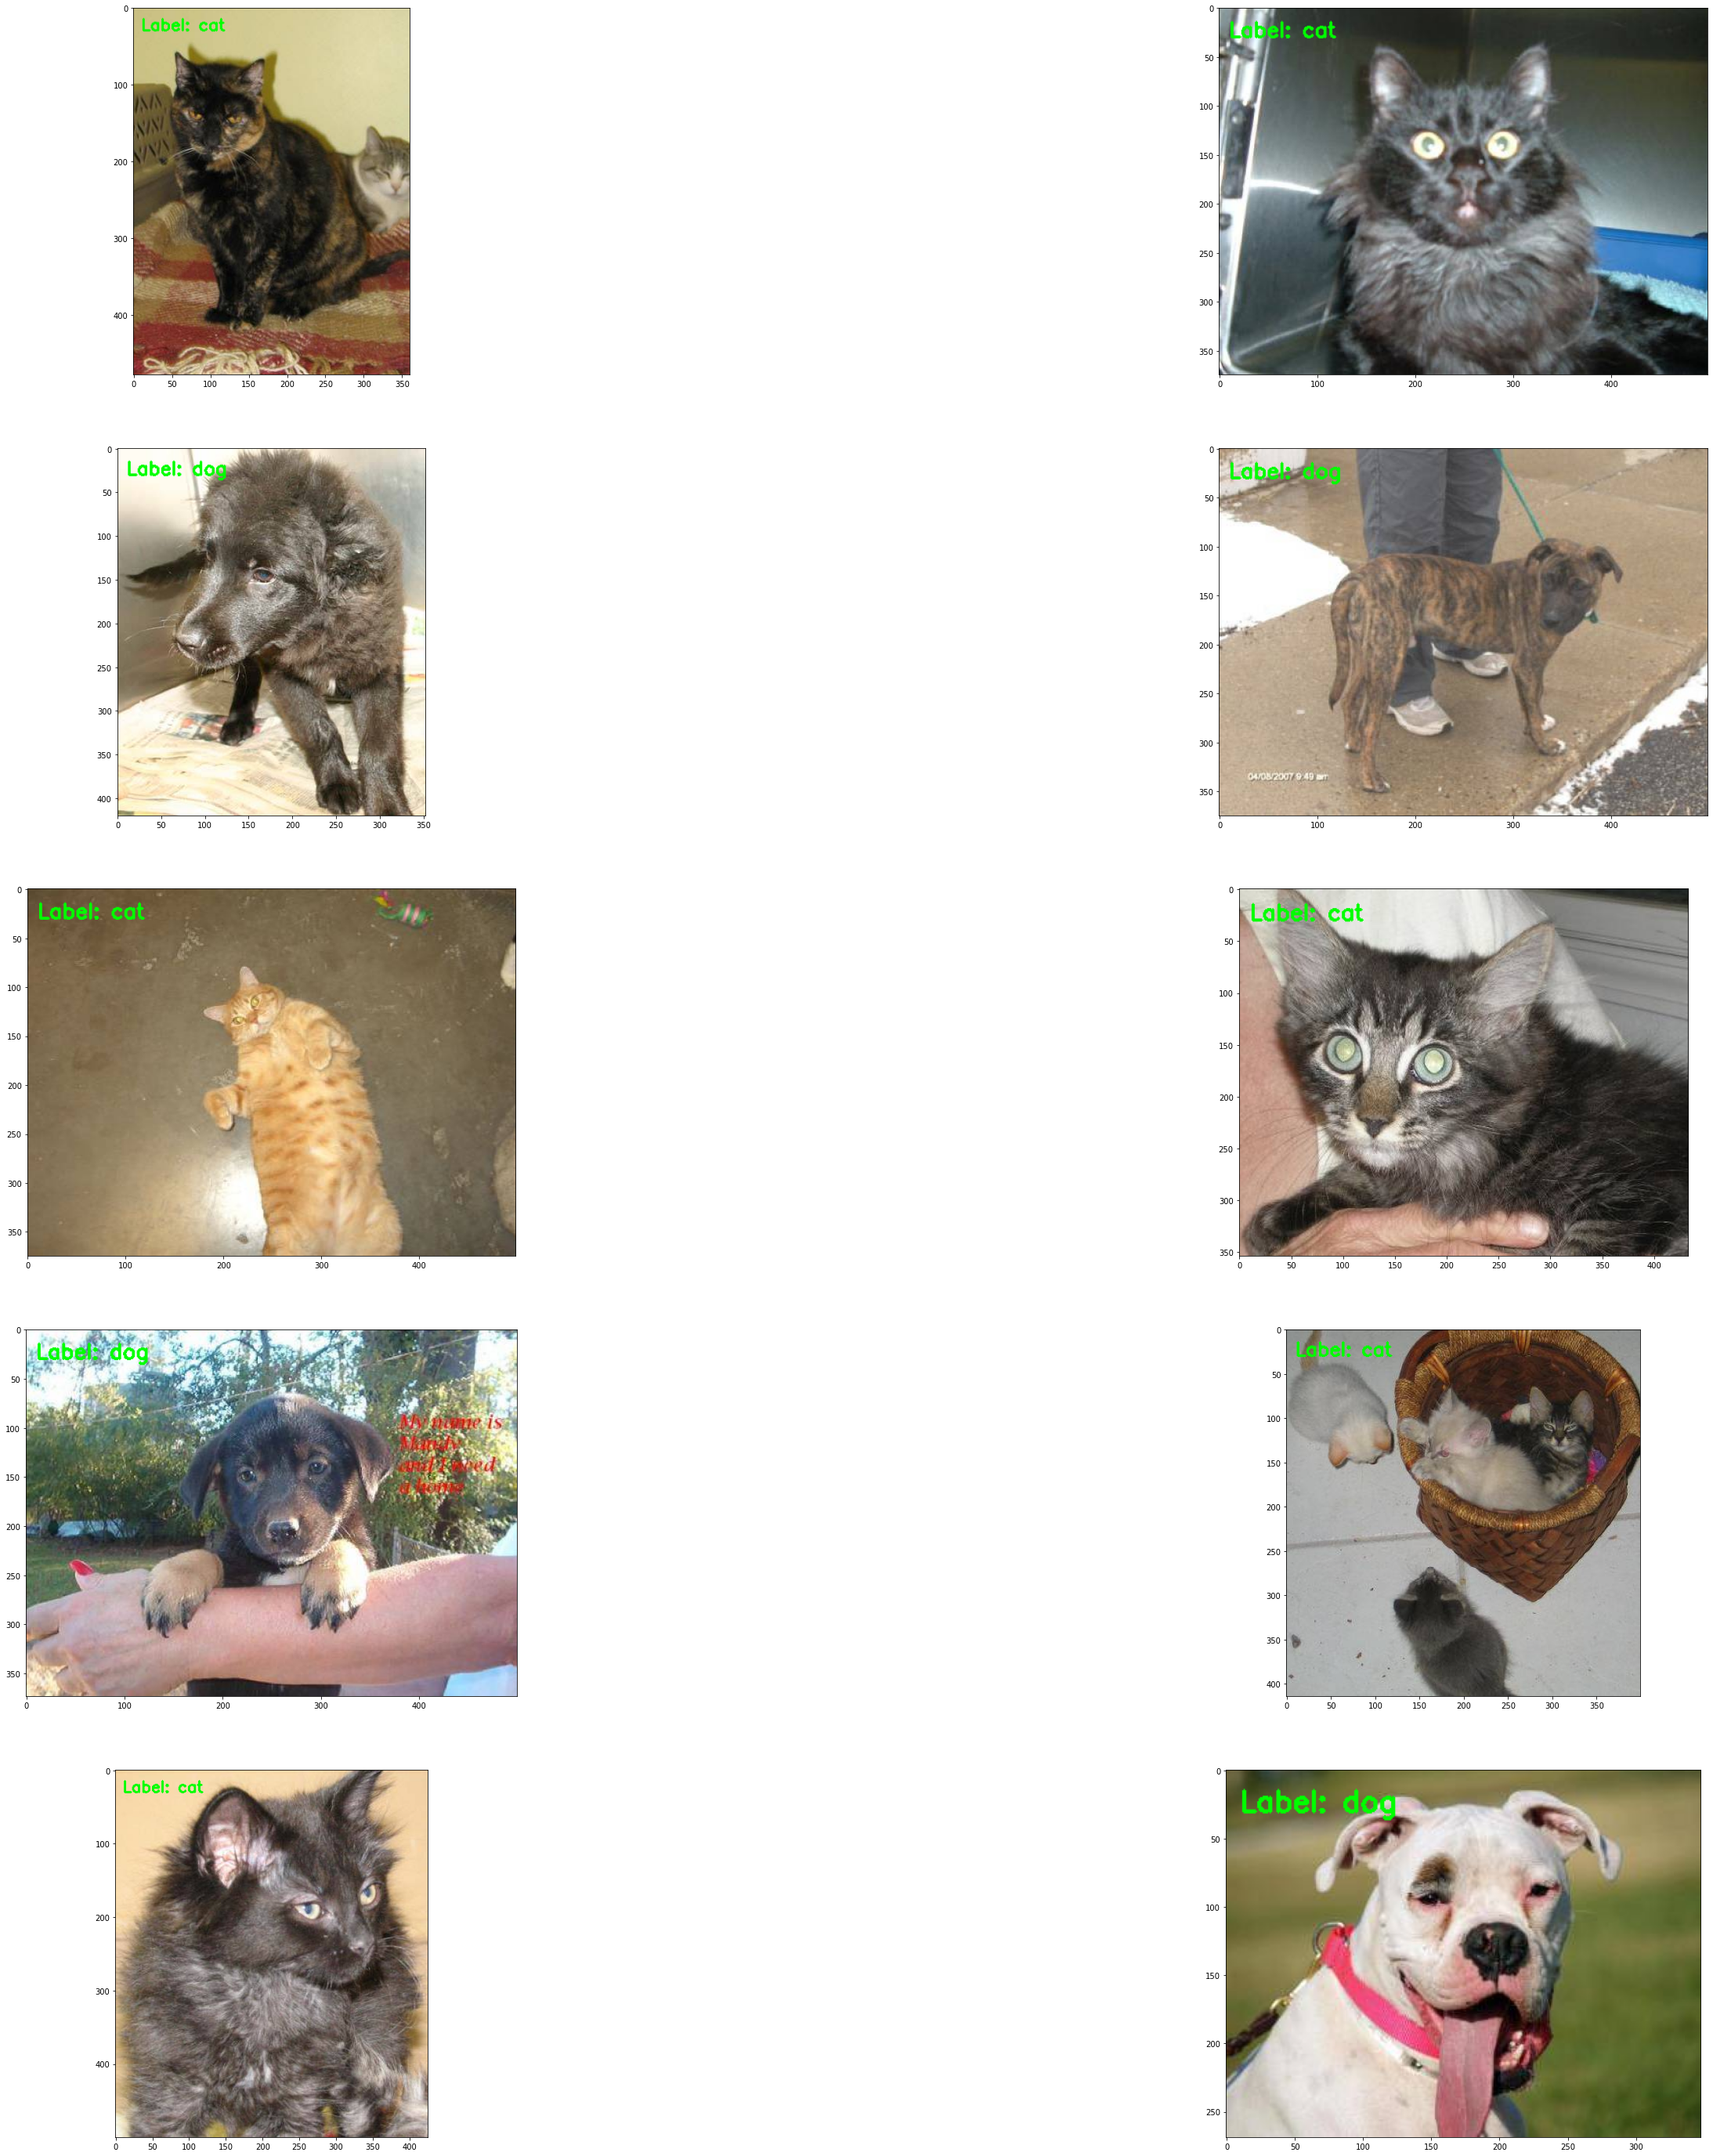

In [28]:
import cv2
import matplotlib.pyplot as plt
classLabels=["cat","dog"]
fig=plt.figure(figsize=(50, 50))
columns = 3
rows = 5
for (i, imagePath) in enumerate(imagePaths):
    # load the example image, draw the prediction, and display it
    # to our screen
    image = cv2.imread(imagePath)
    image= cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    cv2.putText(image, "Label: {}".format(classLabels[prediction[i]]),
    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    fig.add_subplot(rows, columns,i+1)
    plt.imshow( image)
plt.show()
    #cv2.imwrite("{}.jpg".format(str(i)),image)
